# PyTorch - Transfer Learning ConvNet

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import numpy as np

import matplotlib.pyplot as plt

import time
import os 
import copy

plt.ion()

## Data preprocessing / augmentation

In [7]:
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)
    ])
}

data_dir = './hymenoptera_data'
data_folders = ['train', 'val']

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                         data_transforms[x])
                 for x in data_folders}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, 
                                             shuffle=True, num_workers=4)
              for x in data_folders}

dataset_sizes = {x: len(image_datasets[x]) for x in data_folders}

class_names = image_datasets['train'].classes

device = torch.device('cpu')

# Visualize few images

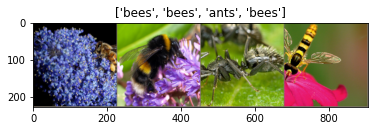

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Training the model

In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Visualize model predictions

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                #ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                ax.set_title('predicted: {}'.format(preds[j]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Finetuning the ConvNet

In [28]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /Users/hernandes/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100.0%


In [31]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6482 Acc: 0.6598
val Loss: 0.3516 Acc: 0.8954

Epoch 1/24
----------
train Loss: 0.5958 Acc: 0.7623
val Loss: 0.4279 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.5943 Acc: 0.7541
val Loss: 0.1831 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.5772 Acc: 0.7869
val Loss: 0.2868 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.5100 Acc: 0.8033
val Loss: 0.3044 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.5194 Acc: 0.7828
val Loss: 0.3226 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.5816 Acc: 0.8033
val Loss: 0.3182 Acc: 0.8824

Epoch 7/24
----------
train Loss: 0.3560 Acc: 0.8525
val Loss: 0.2078 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3786 Acc: 0.8320
val Loss: 0.2012 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.3740 Acc: 0.8443
val Loss: 0.2251 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.2797 Acc: 0.8893
val Loss: 0.1616 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.2386 Acc: 0.9016
val Loss: 0.1897 Acc: 0.9150

Ep

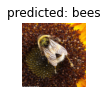

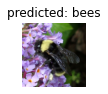

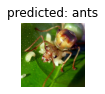

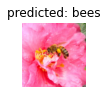

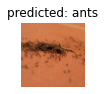

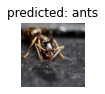

In [34]:
visualize_model(model_ft)

# ConvNet as fixed feature extractor

In [35]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [36]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5203 Acc: 0.7131
val Loss: 0.6818 Acc: 0.7124

Epoch 1/24
----------
train Loss: 0.5606 Acc: 0.7541
val Loss: 0.3389 Acc: 0.8562

Epoch 2/24
----------
train Loss: 0.8149 Acc: 0.6885
val Loss: 0.2435 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4688 Acc: 0.7787
val Loss: 0.2115 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.3506 Acc: 0.8361
val Loss: 0.1968 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.4047 Acc: 0.8484
val Loss: 0.2202 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3301 Acc: 0.8689
val Loss: 0.1622 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3665 Acc: 0.8443
val Loss: 0.1643 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3027 Acc: 0.8770
val Loss: 0.1883 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3524 Acc: 0.8607
val Loss: 0.1498 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3327 Acc: 0.8566
val Loss: 0.1613 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3153 Acc: 0.8525
val Loss: 0.1634 Acc: 0.9542

Ep

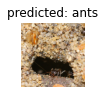

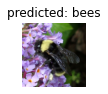

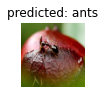

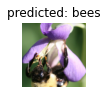

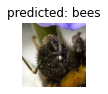

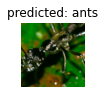

In [37]:
visualize_model(model_conv)

plt.ioff()
plt.show()

# ResNet18 without train

In [8]:
model_conv = torchvision.models.resnet18(pretrained=True)

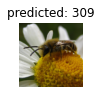

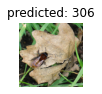

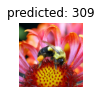

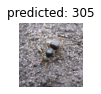

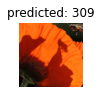

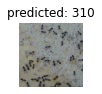

In [14]:
visualize_model(model_conv)